# Generation

In [1]:
import sys
sys.path.append("../python")

In [2]:
import torch
import torchkld
import torchvision

In [3]:
import infomax

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")
print(f"CUDA version: {torch.version.cuda}")

Device: cuda:0
Devices count: 2
CUDA version: 12.1


In [5]:
from misc.modules import *
from misc.plots import *
from misc.training import *
from misc.cGAN import *

2024-11-27 17:04:13.924299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732727053.961441    6459 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732727053.971837    6459 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 17:04:14.015810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
import os
from pathlib import Path

path = Path("../../data/").resolve()
experiments_path = path / "generation/CIFAR10/"
models_path = experiments_path / "models/"
#results_path = experiments_path / "resuts/"

In [7]:
config = {}

## Data

In [8]:
from torchvision.datasets import MNIST, CIFAR10, CIFAR100, ImageNet
from torchvision.models import resnet18, resnet50

In [9]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [10]:
#config["dataset"] = "MNIST"
config["dataset"] = "CIFAR10"
config["n_classes"] = 10

train_dataset = getattr(torchvision.datasets, config["dataset"])(root="./.cache", download=True, transform=image_transform)
test_dataset  = getattr(torchvision.datasets, config["dataset"])(root="./.cache", download=True, transform=image_transform, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
config["batch_size_train"] = 1024
config["batch_size_test"]  = 2048

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size_train"], shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=config["batch_size_test"], shuffle=False)
eval_dataloader  = test_dataloader #torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)

## Model

In [12]:
config["embedding_dim"] = 512

In [13]:
generator = CGANPDGenerator32(condition_dim=config["embedding_dim"], nz=512).to(device)

In [14]:
discriminator = CGANPDDiscriminator32(condition_dim=config["embedding_dim"]).to(device)

### Embedder

In [15]:
config["backbone"] = "resnet18"

if config["backbone"] == "convnet":
    backbone = Conv2dEmbedder(embedding_dim=config["embedding_dim"])
else:
    backbone = getattr(torchvision.models, config["backbone"])().train()
    
    if config["dataset"] in ["CIFAR10", "CIFAR100"]:
        backbone.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False)
        backbone.maxpool = torch.nn.Identity()

In [16]:
state_dict = torch.load(models_path / "vicreg/vicreg-cifar10-01-800.pt")#['state_dict']
backbone_state = {}
for k, v in state_dict.items():
    if k.startswith('backbone.'):
        backbone_state[k[9:]] = v

In [17]:
#backbone.fc = nn.Identity()
backbone.fc = torch.nn.BatchNorm1d(512, affine=False)

backbone.load_state_dict(backbone_state)

<All keys matched successfully>

In [18]:
embedder = torch.nn.Sequential(torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), backbone).to(device).eval()

## Train

In [19]:
def plot_images(images, n_rows: int=2, n_columns: int=6):
    images = np.clip(images.detach().cpu().numpy(), 0.0, 1.0)
    images = images.swapaxes(1, 3)
    images = images.swapaxes(1, 2)

    figure, axes = plt.subplots(n_rows, n_columns, figsize=(3*n_columns, 3*n_rows))

    for index in range(images.shape[0]):
        axes.flatten()[index].imshow(images[index])

    plt.show()

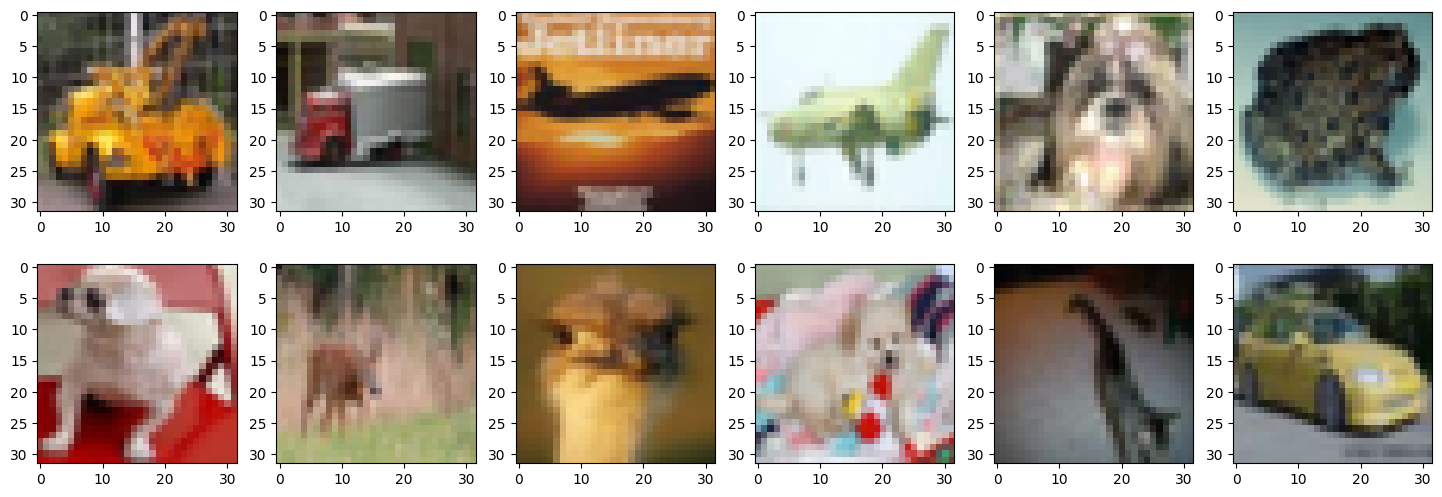

In [20]:
plot_images(next(iter(train_dataloader))[0][:12])

In [21]:
from tqdm import tqdm, trange

In [22]:
class VanillaGANLoss(torch.nn.Module):
    """
    Обычный лосс.
    """
    
    def __init__(self) -> None:
        super().__init__()

    def forward(self, true_images_predictions: torch.tensor, generated_images_predictions: torch.tensor=None) -> torch.tensor:
        return -torch.mean(
            torch.nn.functional.logsigmoid(true_images_predictions) +
            (0.0 if generated_images_predictions is None else torch.nn.functional.logsigmoid(-generated_images_predictions))
        )

In [23]:
def train_cGAN(
    generator,
    discriminator,
    embedder,
    train_dataloader,
    test_dataloader,
    device,
    optimizer_generator,
    optimizer_discriminator,
    n_images=12,
    n_epochs=200,
):
    history = defaultdict(lambda: defaultdict(list))
    optimizer_generator = optimizer_generator(generator.parameters())
    optimizer_discriminator = optimizer_discriminator(discriminator.parameters())

    loss = VanillaGANLoss()

    generator.train()
    discriminator.train()

    step = 0
    for epoch in trange(n_epochs):        
        mean_G_loss = 0.0
        mean_D_loss = 0.0
        mean_G_AE_loss = 0.0

        mean_D_true_value = 0.0
        mean_D_generated_value = 0.0

        n_batches = 0
        for batch in tqdm(train_dataloader):
            #optimizer_embedder_network.zero_grad()
            #optimizer_discriminator_network.zero_grad()
            
            x, y = batch
            x = x.to(device)

            with torch.no_grad():
                embeddings = embedder(x).detach()

            ### Generator
            optimizer_generator.zero_grad()
            generated_images = generator.generate_images(x.shape[0], embeddings)
            generated_images_predictions = discriminator(generated_images, embeddings)
    
            generator_loss = loss(generated_images_predictions)
            _AE_loss = torch.mean((generated_images - x)**2)
            (generator_loss + 1.0e+2 * _AE_loss).backward()
            optimizer_generator.step()

            # DISCRIMINATOR
            optimizer_discriminator.zero_grad()
            true_images_predictions = discriminator(x, embeddings)
            generated_images_predictions = discriminator(generated_images.detach(), embeddings)
            
            discriminator_loss = loss(true_images_predictions, generated_images_predictions)
            discriminator_loss.backward()
            optimizer_discriminator.step()

            mean_D_true_value += true_images_predictions.mean().item()
            mean_D_generated_value += generated_images_predictions.mean().item()
            
            
            mean_G_loss += generator_loss.item()
            mean_D_loss += discriminator_loss.item()
            mean_G_AE_loss += _AE_loss.item()
            n_batches += 1


        step += n_batches
        
        mean_D_true_value /= n_batches
        mean_D_generated_value /= n_batches
        
        history["training"]["mean_D_true_value"].append((epoch, step, mean_D_true_value))
        history["training"]["mean_D_generated_value"].append((epoch, step, mean_D_generated_value))

        mean_G_loss /= n_batches
        mean_D_loss /= n_batches

        history["training"]["G_loss"].append((epoch, step, mean_G_loss))
        history["training"]["D_loss"].append((epoch, step, mean_D_loss))
        history["training"]["mean_G_AE_loss"].append((epoch, step, mean_G_AE_loss))

        #scheduler_embedder_network.step()
        #scheduler_discriminator_network.step()

        clear_output(wait=True)

        # Plots.
        for name, subhistory in history.items():
            plot_history(subhistory, title=name)

        with torch.no_grad():
            generator.eval()

            images = next(iter(train_dataloader))[0][:n_images].to(device)
            plot_images(images)

            embeddings = embedder(images).detach()
            generated_images = generator.generate_images(n_images, embeddings, device=device)

            plot_images(generated_images)

            generator.train()

    return history

In [ ]:
train_cGAN(
    generator,
    discriminator,
    embedder,
    train_dataloader,
    test_dataloader,
    device,
    optimizer_generator=lambda params : torch.optim.Adam(params, lr=5.0e-3),
    optimizer_discriminator=lambda params : torch.optim.Adam(params, lr=2.0e-3),
    n_images=12,
    n_epochs=1,
)

In [ ]:
1